In [1]:
# Подключенине библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from custom_modules import data_processing as dp
import custom_modules.PipeData as pidf

from matplotlib import ticker
from IPython.display import display
from tensorflow import keras

In [2]:
def draw_map(data_map):
    with plt.style.context('dark_background'):
            fig, ax = plt.subplots()
        
            fig.set_figwidth(18)
            fig.set_figheight(8)
            fig.patch.set_alpha(0.0)
        
            ax.invert_yaxis()
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
            ax.set_title("Предсказанная развернутая карта дефектов", fontsize=25)
            ax.set_xlabel('Номер датчика', fontsize=20)
            ax.set_ylabel('Номер измерения', fontsize=20)
            ax.tick_params(axis='both', labelsize = 20)

            map = ax.pcolormesh(data_map)
            cbar = fig.colorbar(map)
            cbar.ax.tick_params(labelsize=20)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    
    plt.show()

In [3]:
#PATH = 'data/Drawing data/Run1/model_id=0_crop(size=64,step=4)_shift(x=0,y=0).xlsx'
#or_res_df = pd.read_excel(PATH, sheet_name='orig_res', index_col=0, dtype=np.float64)
#ex_res_df = pd.read_excel(PATH, sheet_name='extend_res', index_col=0, dtype=np.float64)
#or_ref_df = pd.read_excel(PATH, sheet_name='orig_reference', index_col=0, dtype=np.float64)
#ex_ref_df = pd.read_excel(PATH, sheet_name='extend_reference', index_col=0, dtype=np.float64)

In [4]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/Original data/Run1/run1_WM32_data.csv',
        'data/Original data/Run1/run1_WM32_defects.csv',
        'data/Original data/Run1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/Original data/Run2/run2_WM32_data.csv',
        'data/Original data/Run2/run2_WM32_defects.csv',
        'data/Original data/Run2/run2_WM32_pipe.csv')
}

CROP_SIZE = 16
CROP_STEP = 4
SHIFT = {'x': 0, 'y': 0}

PATH_TO_MODEL = 'networks/CNN/id=03_in(16x64+16x64)_out(1)_train=0dot0_test=0dot0038.h5'

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# чтение данных
test_1 = pidf.PipeDataCsvWorker(*PATH_TO_DATA['run_1'])
orig_x_data = test_1.get_data_df()
orig_y_data = test_1.get_defects_df()

ORIG_df_cols = orig_x_data.shape[1]
ORIG_df_rows = orig_x_data.shape[0]

test_1.extend_dfs_for_prediction(crop_size=CROP_SIZE, crop_step=CROP_STEP)
extend_x_data = test_1.get_data_df()
extend_y_data = test_1.get_defects_df()

PREP_df_cols = extend_x_data.shape[1]
PREP_df_rows = extend_x_data.shape[0]

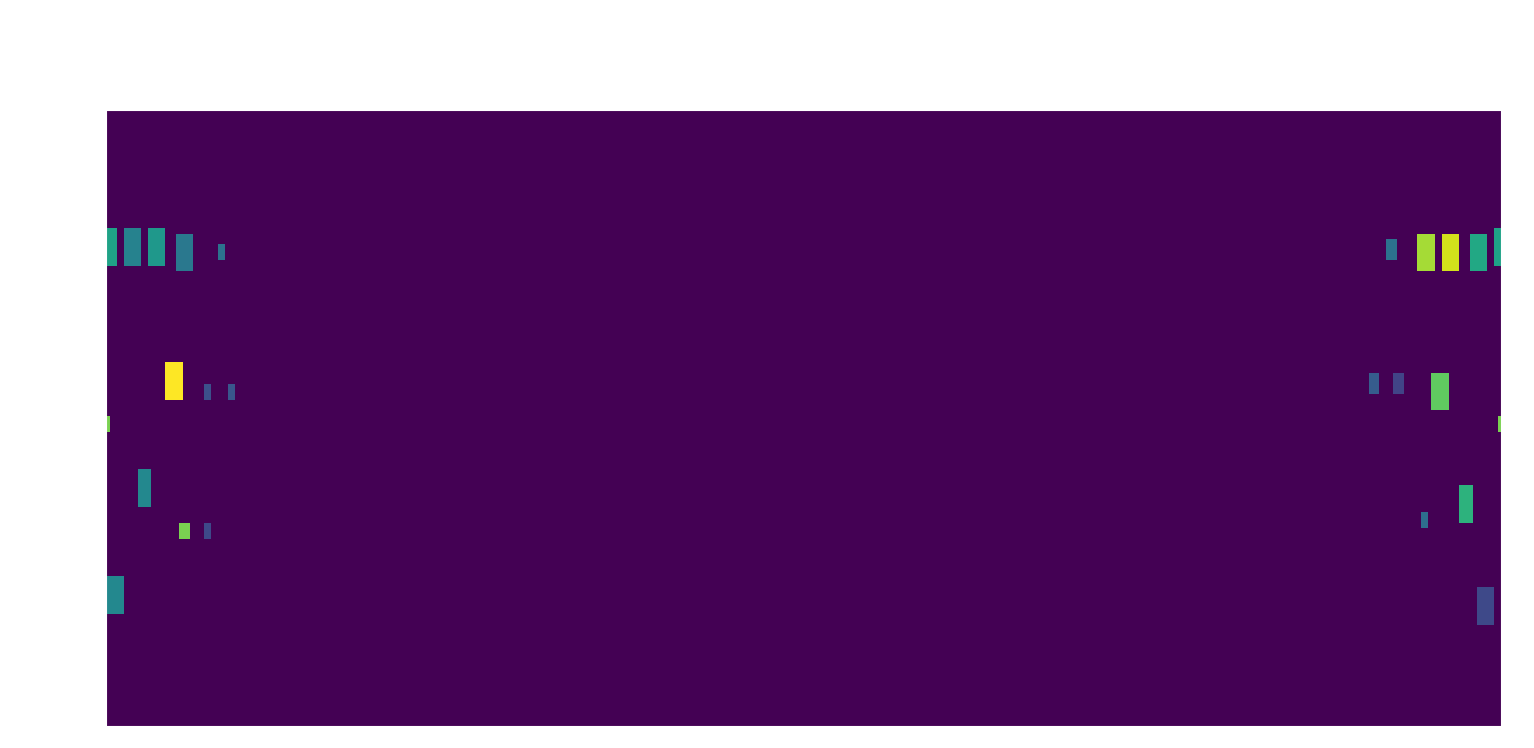

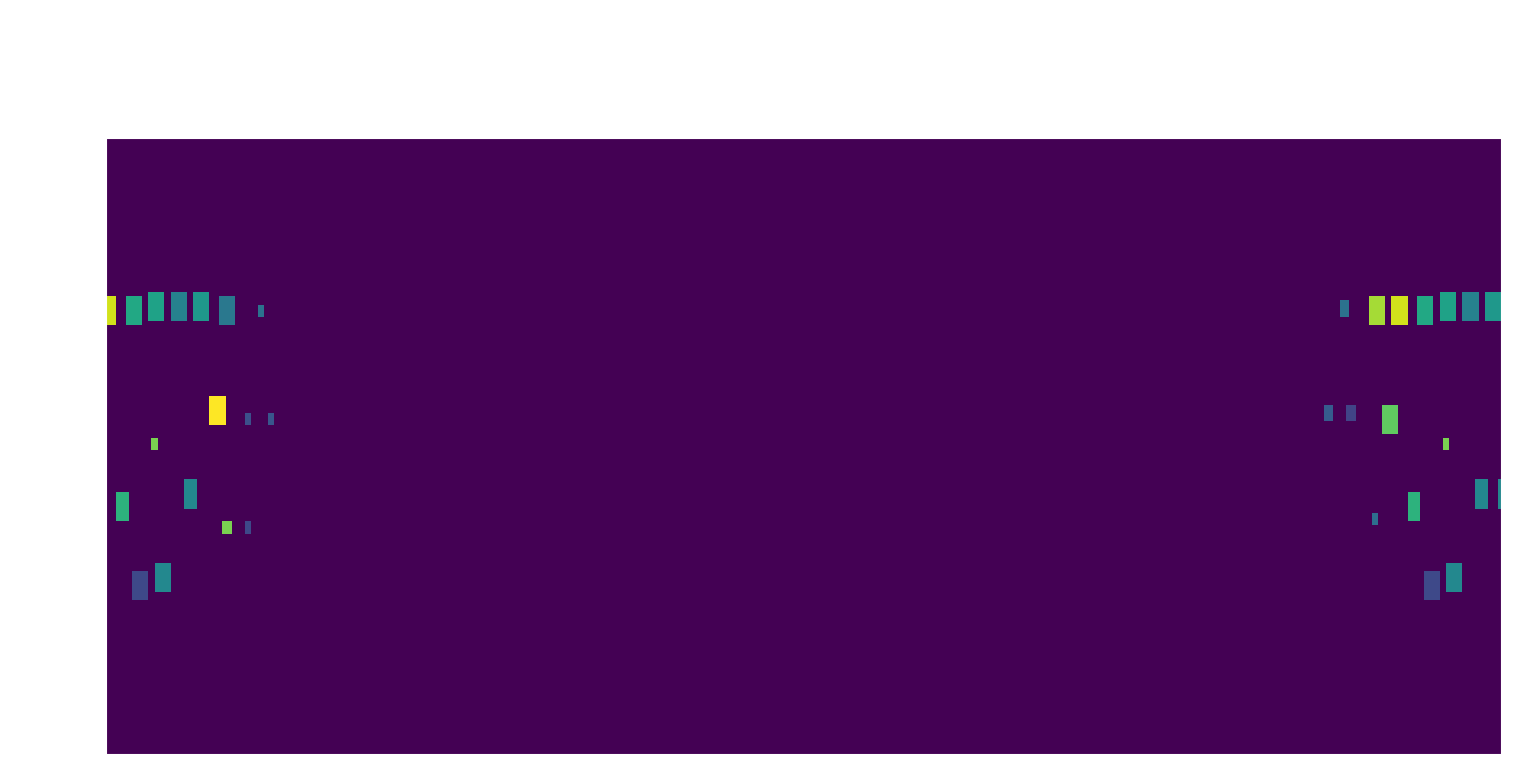

In [5]:
# Вывод считанных данных и их расширение для обучения

test_1.reset_dfs_to_original()
test_1.draw_defects_map(title='Считанная развернутая карта дефектов')

test_1.extend_dfs_for_prediction(crop_size=CROP_SIZE, crop_step=CROP_STEP)
test_1.draw_defects_map(title=f'Расширенная развернутая карта дефектов для cr.size: {CROP_SIZE} и cr.step: {CROP_STEP}')

In [6]:
# Запишем размеры датафреймов до обработки
# Забрать данные из класса
x_data = test_1.get_data_df()
y_data = test_1.get_defects_df()
test_1 = None

In [7]:
# Загрузка модели
model = keras.models.load_model(PATH_TO_MODEL)

In [8]:
# нормализация значений массива
def normalize_data(arr): 
    return  arr / arr.max()

In [9]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

# y = x + k
def draw_prediction_map_2_0(model, df, orig_rows_count, orig_cols_count,
                                    result_rows_count, result_cols_count, 
                                    crop_size, step = -1):

    print('||||||||||||||||||')
    print('draw_prediction_map_2_0')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.ones((result_rows_count, result_cols_count))     

    center = crop_size // 2 
    
    for i in range(0, result_rows_count - crop_size + 1, step): 
        print(f'row: {i} of {result_rows_count}')
        for j in range(0, result_cols_count - crop_size + 1, step):
            temp_crop = dp.pandas_crop_to_image_like_numpy(df.iloc[i:i+crop_size,j:j+crop_size])
            temp_crop = np.expand_dims(temp_crop, axis=0)
            temp_crop = normalize_data(temp_crop)
            res = model.predict([temp_crop[:,:,:,:32], temp_crop[:,:,:,32:]])

            if res[0] >= 0.5:
                new_arr[i:i+crop_size,j:j+crop_size][:center,:center] += res[0]
            else:
                new_arr[i:i+crop_size,j:j+crop_size][:center,:center] -= res[0]
    

    left_up_border = crop_size - 1
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    orig_arr = new_arr[left_up_border:,left_up_border:][:orig_rows_count,:orig_cols_count]
    extend_arr = new_arr
    
    orig_df = pd.DataFrame(data=orig_arr, 
                           columns=df.columns.tolist()[left_up_border:][:orig_cols_count], 
                           index=df.index.tolist()[left_up_border:][:orig_rows_count])

    extend_df = pd.DataFrame(data=extend_arr, columns=df.columns, index=df.index)
    
    return orig_df, extend_df, orig_arr, extend_arr 

In [10]:
df, ex_df, or_arr, ex_arr = draw_prediction_map_2_0(model, x_data,
                                   ORIG_df_rows, ORIG_df_cols,
                                   PREP_df_rows, PREP_df_cols, 
                                   CROP_SIZE, CROP_STEP)

||||||||||||||||||
draw_prediction_map_2_0
Crop windows height/width:  16
Crop windows step across rows and cols:  4
row: 0 of 148
1/1 [==============================] - 0s 149ms/step
row: 4 of 148
1/1 [==============================] - 0s 146ms/step
row: 8 of 148
1/1 [==============================] - 0s 163ms/step
row: 12 of 148
1/1 [==============================] - 0s 156ms/step
row: 16 of 148
1/1 [==============================] - 0s 157ms/step
row: 20 of 148
1/1 [==============================] - 0s 245ms/step
row: 24 of 148
1/1 [==============================] - 0s 149ms/step
row: 28 of 148
1/1 [==============================] - 0s 167ms/step
row: 32 of 148
1/1 [==============================] - 0s 188ms/step
row: 36 of 148
1/1 [==============================] - 0s 163ms/step
row: 40 of 148
1/1 [==============================] - 0s 159ms/step
row: 44 of 148
1/1 [==============================] - 0s 158ms/step
row: 48 of 148
1/1 [==============================] - 0s 158ms/step
ro

In [11]:
tor_arr = np.zeros(or_arr.shape)
tex_arr = np.zeros(ex_arr.shape)

for i in range(or_arr.shape[0]):
    for j in range(or_arr.shape[1]):
        if or_arr[i,j] > np.mean(or_arr):
            tor_arr[i,j] = 1

for i in range(ex_arr.shape[0]):
    for j in range(ex_arr.shape[1]):
        if ex_arr[i,j] > np.mean(ex_arr):
            tex_arr[i,j] = 1

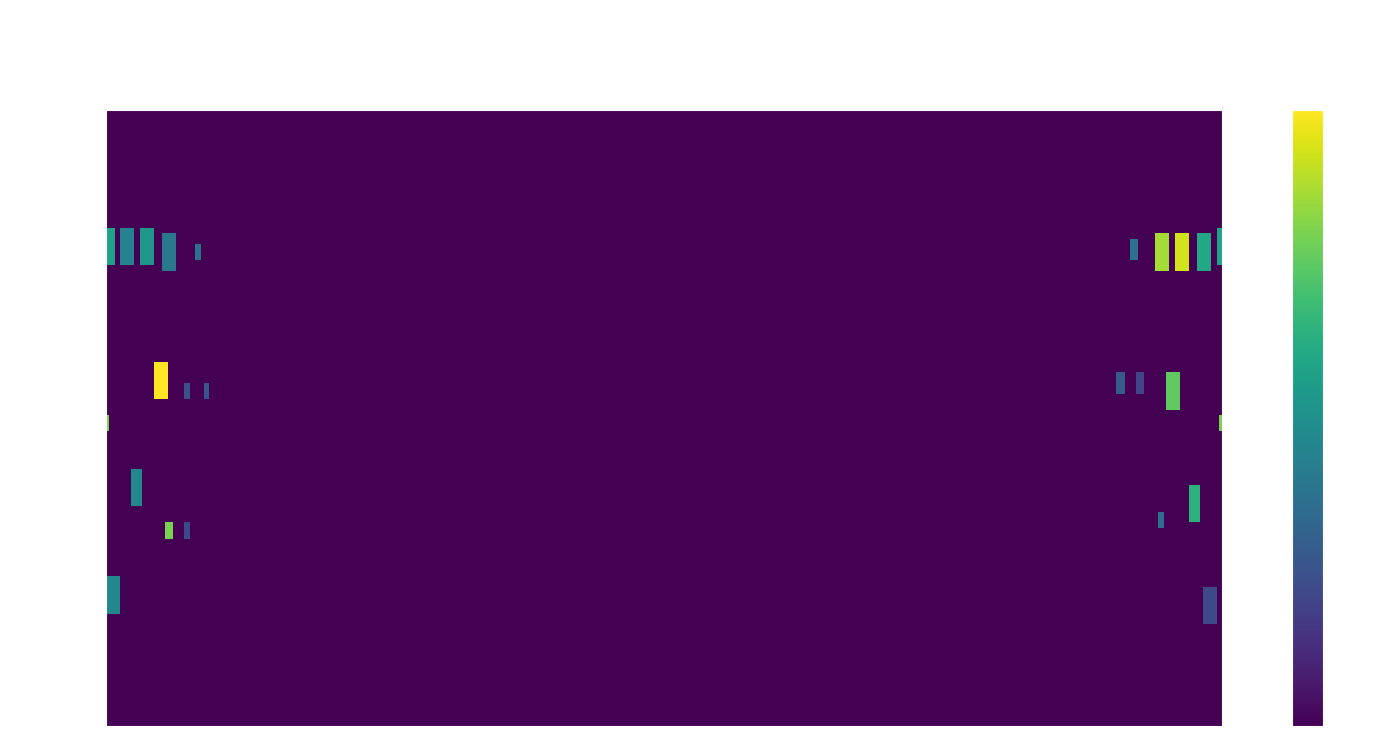

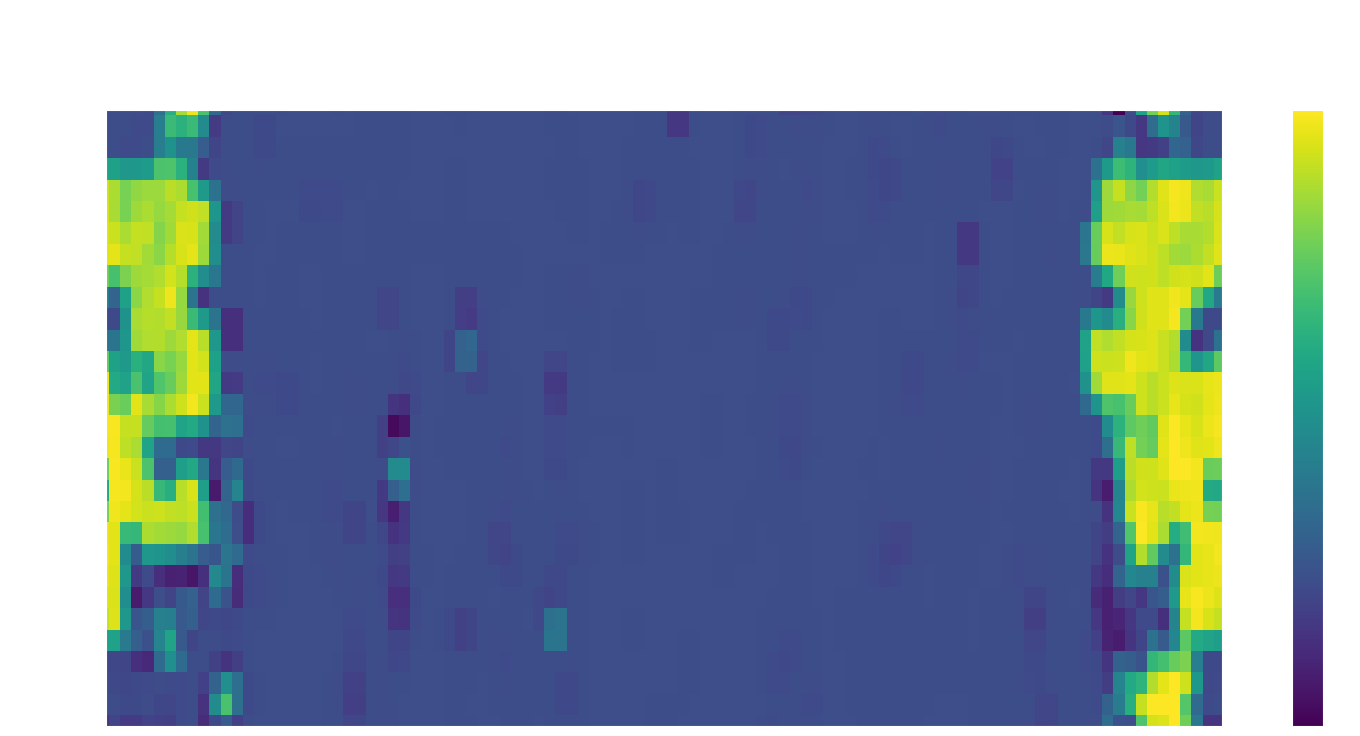

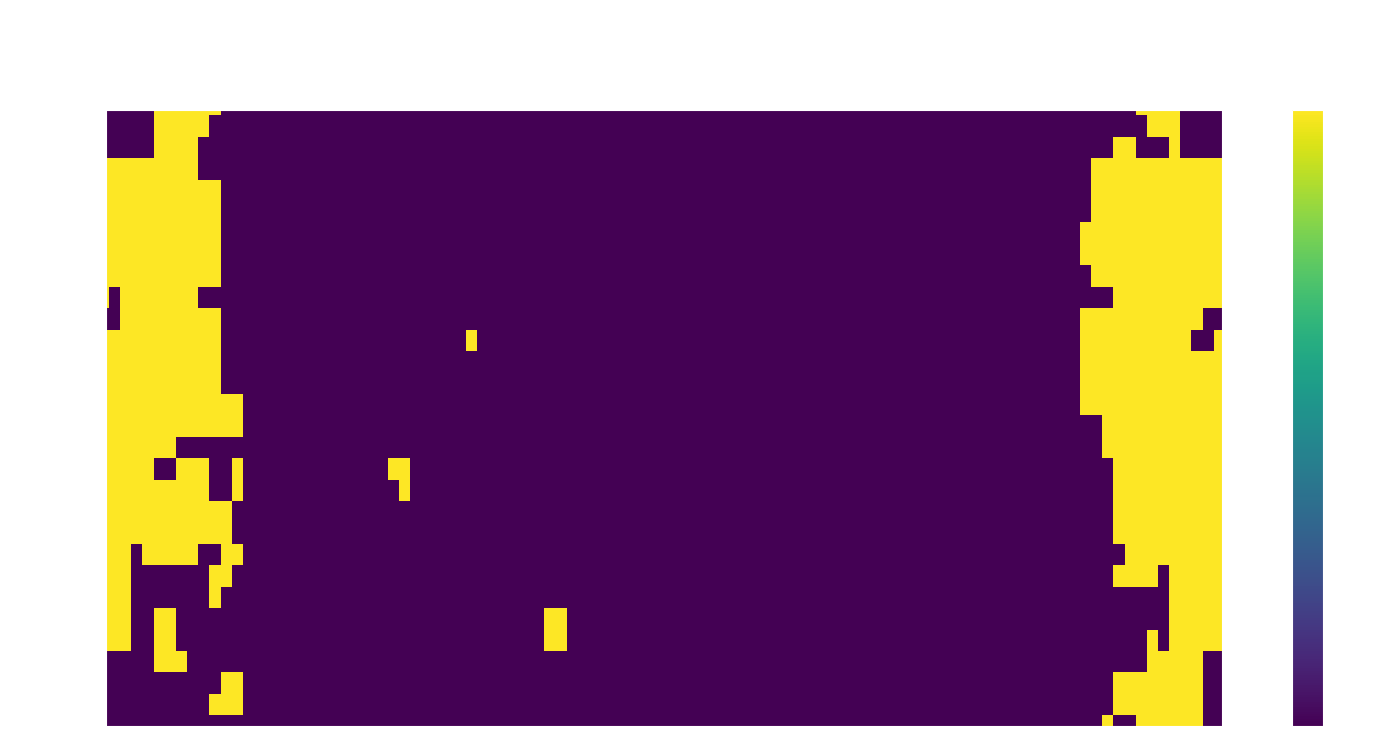

In [12]:
draw_map(orig_y_data)
draw_map(or_arr)
draw_map(tor_arr)

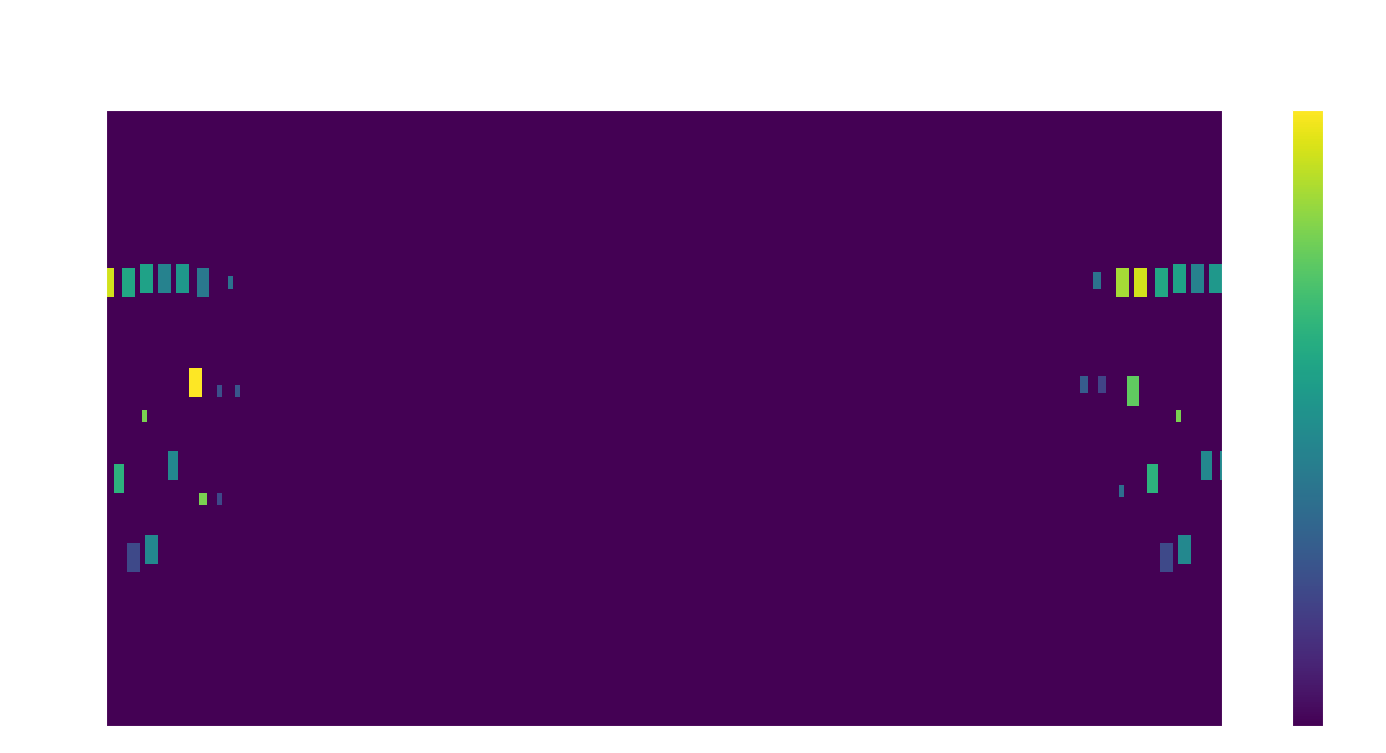

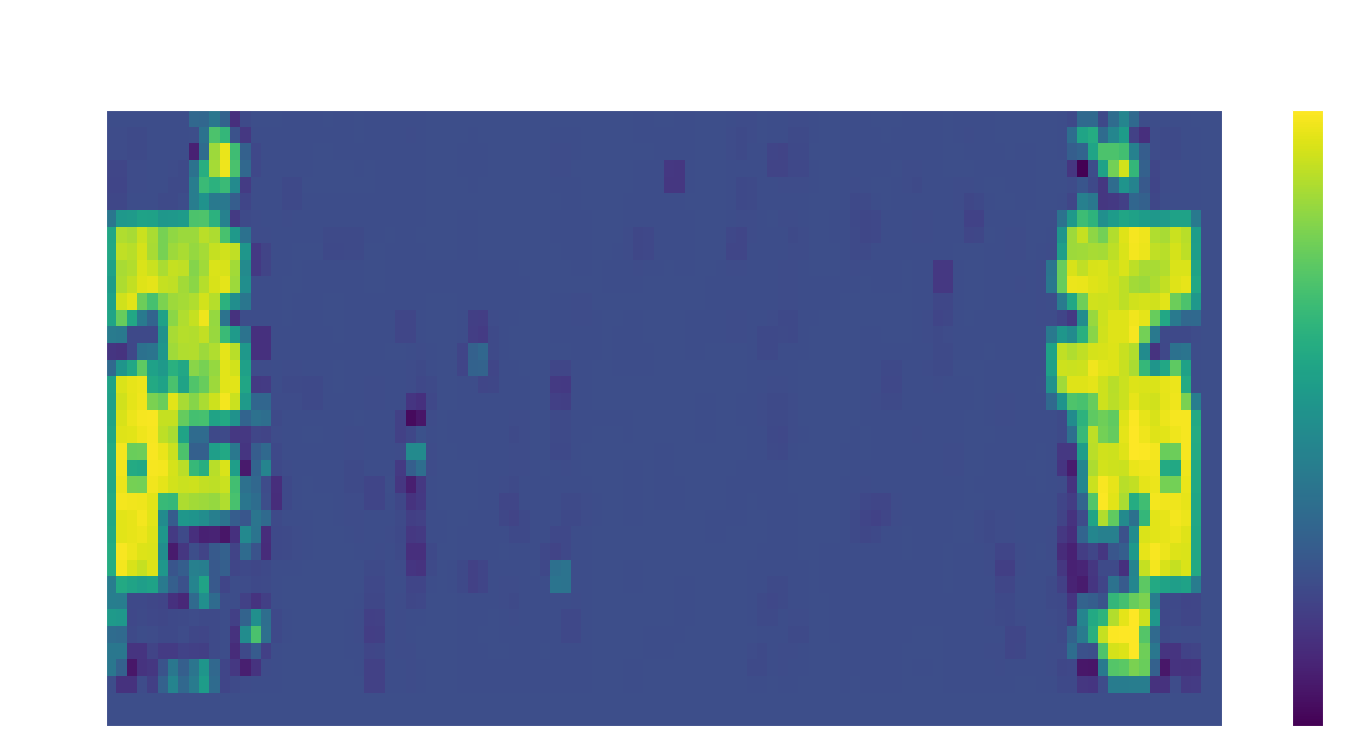

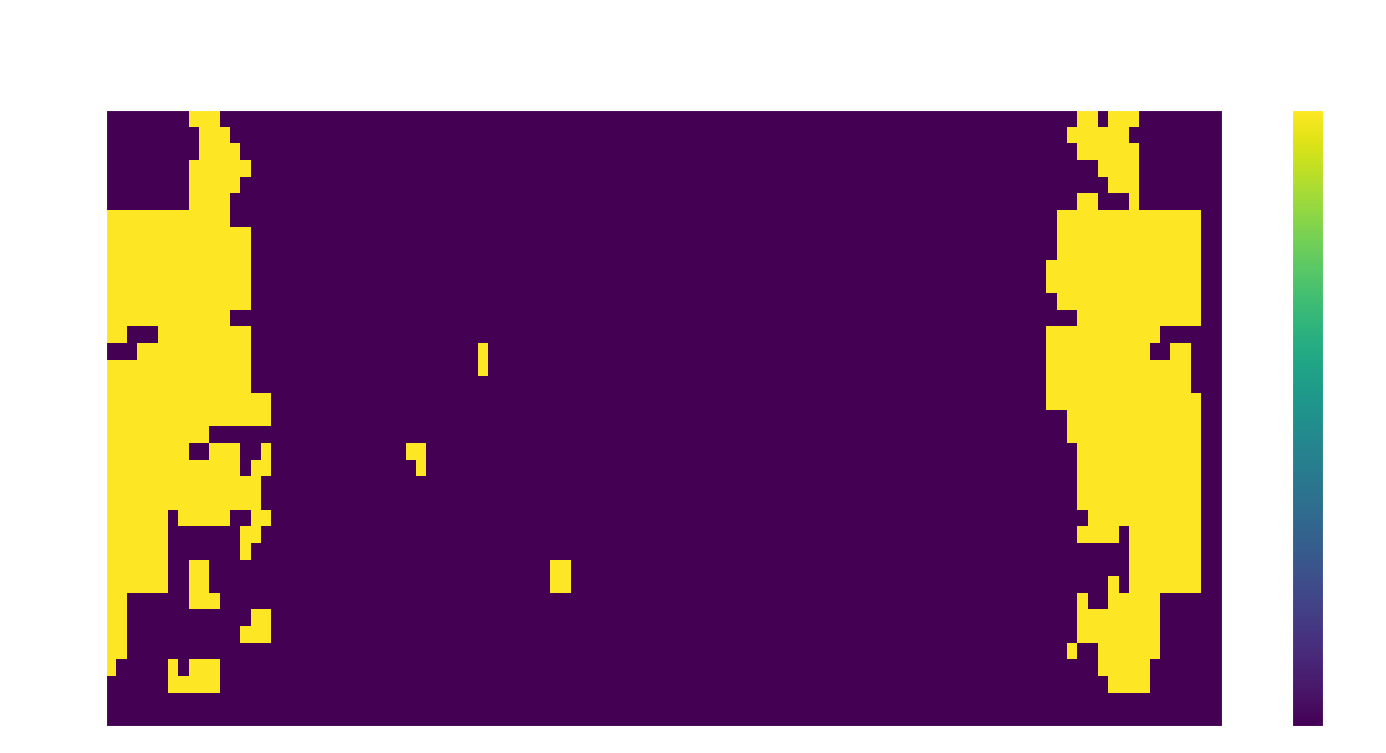

In [13]:
draw_map(extend_y_data)
draw_map(ex_arr)
draw_map(tex_arr)

In [14]:
path = 'data/Drawing data/Run1/' + f'model_id=03_crop(size={CROP_SIZE},step={CROP_STEP})_shift(x={SHIFT["x"]},y={SHIFT["y"]}).xlsx'

with pd.ExcelWriter(path) as writer:  
    df.to_excel(writer, sheet_name='orig_res')
    ex_df.to_excel(writer, sheet_name='extend_res')
    orig_y_data.to_excel(writer, sheet_name='orig_reference')
    extend_y_data.to_excel(writer, sheet_name='extend_reference')